In [31]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [32]:
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report


#from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [33]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', '..', 'input')
outDir = '../output'
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'A04_fashion_vanila'
# log_dir = PATH('')

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


In [34]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : labels in a dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    if isinstance(labels, dict):
        display_labels = labels.values()
    else:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize = (4,4))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

    # Disable the grid
    ax.grid(False)

    plt.show()


In [35]:
def fn_plot_tf_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

In [36]:
###-----------------
### Hyper Parameters
###-----------------

EPOCHS = 200 # number of epochs
ALPHA = 0.0003 # learning rate
BATCH_SIZE = 64 # mini batch size (number of rows)
TEST_SIZE = 0.2 # test size for train-test split
TRAIN_SIZE=int(18 *BATCH_SIZE)
WEIGHT_DECAY=0.001 # ADAMW
PATIENCE=20 # for Early Stopping
LR_FACTOR =0.1#Reduction on LR Factor
LR_PATIENCE=3 # how long should i wait
MIN_LR = 1e-6#min

In [37]:
start = -2.1
end = 2.1
delta = 0.001
#training data
X_train = np.arange(start,end+delta, delta)
y_true = 2* np.square(X_train) +2*np.sin(np.pi*X_train)  #2*X + 2*sin(X)
y_rng = np.random.rand(X_train.shape[0]) - 0.5
y_train = y_true + y_rng *2

#testing data
X_test = np.arange(start,end+delta, delta*10)
y_true_test = 2* np.square(X_test) +2*np.sin(np.pi*X_test)  #2*X + 2*sin(X)
y_rng = np.random.rand(X_test.shape[0]) - 0.5
y_test = y_true_test + y_rng*2
y_train.min(), y_train.max()

(np.float64(-2.554991860689859), np.float64(10.368558250506306))

In [38]:
X_train.shape[0]/BATCH_SIZE

65.640625

In [39]:
num_examples = 262 * BATCH_SIZE

X_train = X_train[: num_examples]
y_train = y_train[: num_examples]
y_true = y_true[: num_examples]
X_train.shape, y_train.shape, y_true.shape

((4201,), (4201,), (4201,))

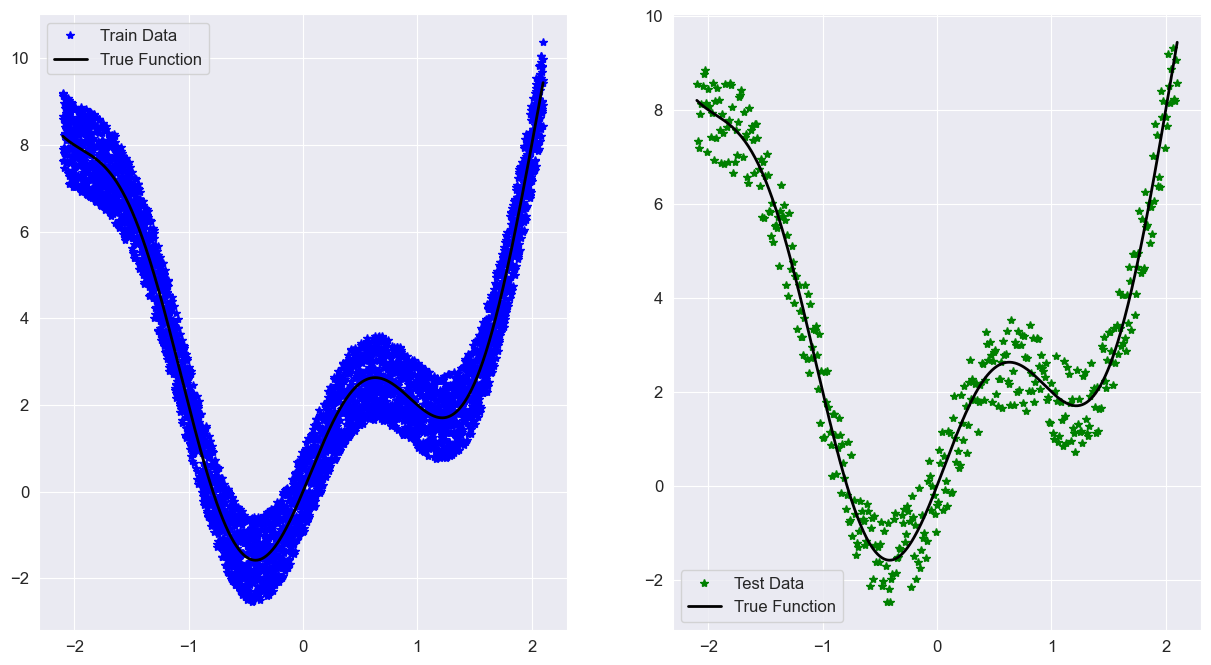

In [40]:
fig,axes = plt.subplots(1,2)
ax = axes[0]
ax.plot(X_train, y_train, 'b*', label='Train Data')
ax.plot(X_train, y_true, c ='k', linewidth =2, label='True Function')
ax.legend()

ax = axes[1]
ax.plot(X_test, y_test, 'g*', label='Test Data')
ax.plot(X_test, y_true_test, c ='k', linewidth =2, label='True Function')
ax.legend();

In [41]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))  

In [42]:
train_ds = train_ds.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size=X_test.shape[0]).batch(BATCH_SIZE)

In [43]:
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
next(iter(train_ds))

(<tf.Tensor: shape=(64,), dtype=float64, numpy=
 array([-0.166,  0.3  ,  1.008, -0.336,  0.433,  0.86 , -1.627,  1.484,
        -1.391,  0.318, -1.007,  0.289,  0.49 , -0.58 , -0.118, -0.269,
         0.866, -1.675, -1.396,  1.758, -1.438,  0.437,  2.037, -1.596,
         0.588,  1.339,  1.243, -1.299, -1.55 , -1.946,  0.52 , -1.165,
        -0.806,  0.518,  1.115, -2.05 , -1.169, -2.012,  1.643,  1.462,
         1.335, -0.632,  0.818, -1.231, -2.004,  2.095, -0.99 ,  0.99 ,
        -0.894, -0.209, -1.184, -1.783,  0.255,  1.501, -2.041,  1.743,
         0.893, -1.988, -1.985, -2.061,  1.363, -0.296, -0.578, -0.088])>,
 <tf.Tensor: shape=(64,), dtype=float64, numpy=
 array([-1.37747328,  2.2909299 ,  1.89157305, -1.5311818 ,  1.5707243 ,
         1.75688239,  7.02455618,  2.42606145,  6.1745375 ,  2.06253532,
         2.1770797 ,  0.76570631,  2.24430999, -1.30564634, -0.43968458,
        -1.43613083,  1.42499514,  7.19929249,  6.30470927,  4.60707559,
         6.15907015,  2.26935862,

In [45]:
for features, labels in train_ds.take(1):
    print(features.shape, labels.shape)

(64,) (64,)


## Define Model 
Functinal API

In [46]:
num_features = 1
# initializer = tf.keras.initializers.HeUniform(seed=RANDOM_STATE)

input_layer = tf.keras.Input(shape=(1,))
hidden_layer = tf.keras.layers.Dense(512, activation = 'relu') (input_layer)
hidden_layer = tf.keras.layers.Dense(256, activation = 'relu') (hidden_layer)
output_layer = tf.keras.layers.Dense(1) (hidden_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
print(model)


<Functional name=functional_1, built=True>


In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
loss_fn = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.MeanAbsoluteError()

In [48]:
model.compile(optimizer = optimizer, loss = loss_fn, metrics = [metrics])

with Batch normalization

In [49]:
#call backs:
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir = 'logDir'
)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = PATIENCE,
    verbose = 1,
    restore_best_weights =True
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = LR_FACTOR,
    patience = LR_PATIENCE,
    verbose = 1,
    mode = 'auto',
    min_lr = MIN_LR,
)

In [50]:
history = model.fit(train_ds,validation_data = test_ds,callbacks = [es_callback,lr_callback], epochs = EPOCHS)

Epoch 1/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.3138 - mean_absolute_error: 2.3681 - val_loss: 3.8045 - val_mean_absolute_error: 1.6475 - learning_rate: 3.0000e-04
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3500 - mean_absolute_error: 1.5102 - val_loss: 2.8853 - val_mean_absolute_error: 1.4057 - learning_rate: 3.0000e-04
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5270 - mean_absolute_error: 1.2985 - val_loss: 2.1228 - val_mean_absolute_error: 1.1969 - learning_rate: 3.0000e-04
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8071 - mean_absolute_error: 1.0879 - val_loss: 1.5343 - val_mean_absolute_error: 0.9967 - learning_rate: 3.0000e-04
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3818 - mean_absolute_error: 0.9276 - val_loss: 1.3128 - val_mean_absolute_error: 0.8934 - learning_rate: 3.0000e-04
Epoch 6/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2454 - mean_absolute_error: 0.8632 - val_loss: 1.2572 

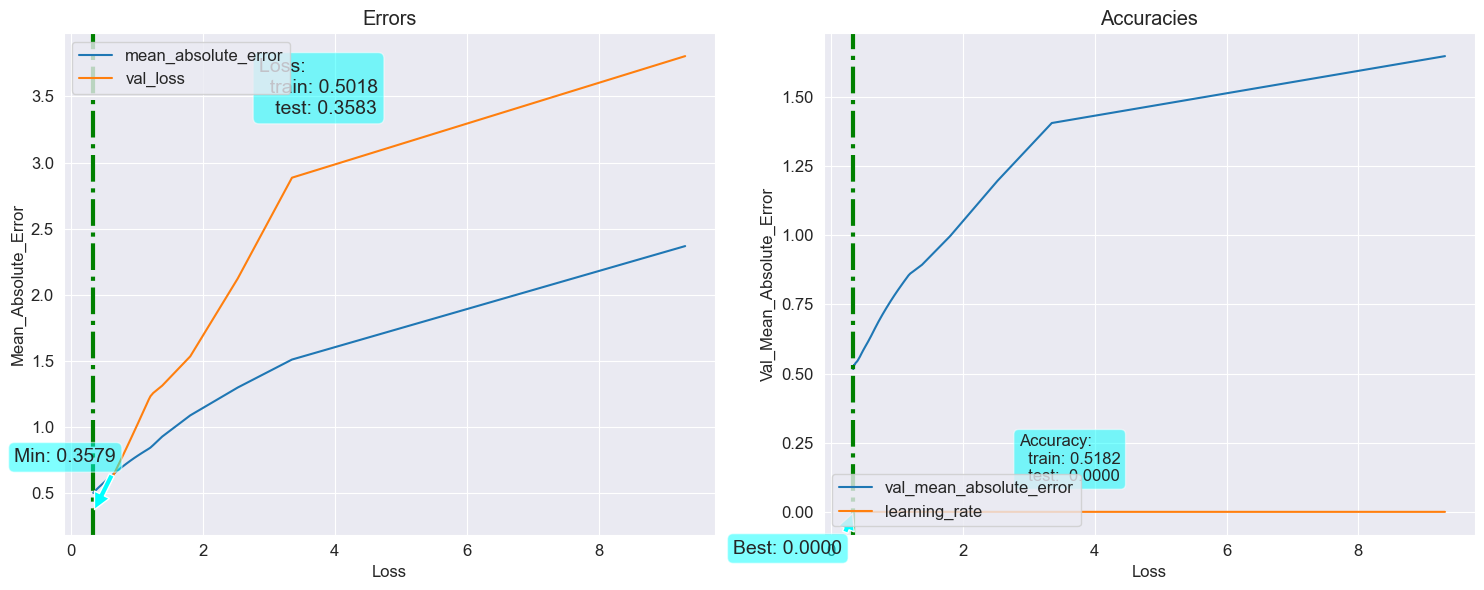

In [51]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)
# history.history

In [52]:
model.evaluate(train_ds, verbose= 2)
model.evaluate(test_ds, verbose= 2)

66/66 - 0s - 2ms/step - loss: 0.3366 - mean_absolute_error: 0.5019
7/7 - 0s - 4ms/step - loss: 0.3579 - mean_absolute_error: 0.5186


[0.3579072952270508, 0.5186076164245605]

In [53]:
y_true, y_pred =[],[]
for feat, lbls in train_ds:
    pred = model(feat).numpy()
    y_true.extend(lbls)
    y_pred.extend(pred.argmax(axis=1))
print(f'Accuracy:{accuracy_score(y_true,y_pred)}')
print(classification_report(y_true, y_pred))

ValueError: Classification metrics can't handle a mix of continuous and binary targets